In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [23]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [24]:
train_path = 'dataset_rahin/training'
valid_path = 'dataset_rahin/validation/gallery'

In [25]:
# add preprocessing layer to the front of ResNet50
resnet50 = tf.keras.applications.ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train resnet50 weights
for layer in resnet50.layers:
  layer.trainable = False

In [26]:
# useful for getting number of classes
folders = glob(train_path+'/*')

print(len(folders))

98


In [27]:
# our layers - you can add more if you want
x = Flatten()(resnet50.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [28]:
# create a model object
model = Model(inputs=resnet50.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [29]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [30]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.3)

# test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset='training')

test_set = train_datagen.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset='validation')




# training_set,test_set=train_test_split(training_set,test_size=0.3,random_state=421)

Found 33638 images belonging to 98 classes.
Found 14399 images belonging to 98 classes.


In [32]:
# fit the model
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=50,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy'
        )
    ]
)

Epoch 1/50
1052/1052 [==============================] - 546s 519ms/step - loss: 6.3437 - accuracy: 0.3853 - val_loss: 6.3548 - val_accuracy: 0.2506
Epoch 2/50
1052/1052 [==============================] - 460s 438ms/step - loss: 5.4619 - accuracy: 0.4601 - val_loss: 5.6618 - val_accuracy: 0.3545
Epoch 3/50
1052/1052 [==============================] - 456s 433ms/step - loss: 5.2995 - accuracy: 0.4856 - val_loss: 6.5538 - val_accuracy: 0.2590
Epoch 4/50
1052/1052 [==============================] - 449s 426ms/step - loss: 5.1761 - accuracy: 0.5036 - val_loss: 5.7234 - val_accuracy: 0.3666
Epoch 5/50
1052/1052 [==============================] - 437s 415ms/step - loss: 5.0985 - accuracy: 0.5155 - val_loss: 6.0696 - val_accuracy: 0.3527
Epoch 6/50
1052/1052 [==============================] - 435s 413ms/step - loss: 5.0629 - accuracy: 0.5249 - val_loss: 6.1805 - val_accuracy: 0.3481
Epoch 7/50
1052/1052 [==============================] - 440s 418ms/step - loss: 5.0191 - accuracy: 0.5287 - val_

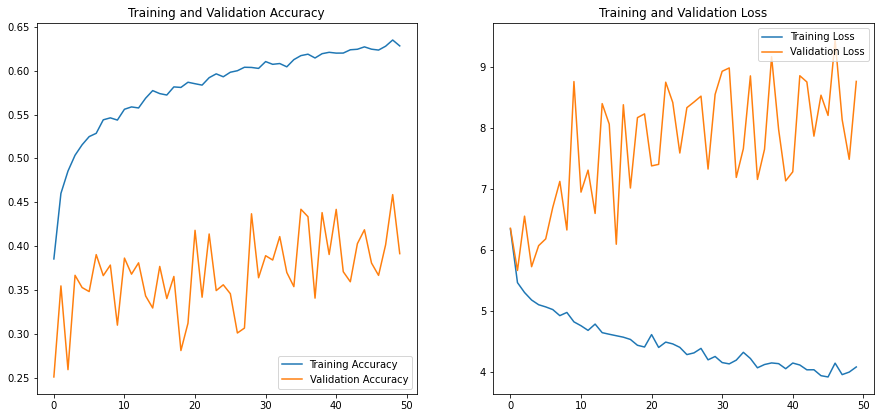

In [34]:
# accuracies
accs = r.history['accuracy']
val_accs = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accs, label='Training Accuracy')
plt.plot(epochs_range, val_accs, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()